In [1]:
from pylab import *
import nylib, nylib2, cjlib, cxlib
import pandas as pd
import mouseProcessing
import B0Correction
import numpy
import cv2
%matplotlib inline

# T2

In [2]:
save_dir = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M1-3/'
mouse = 'M1_3'

from scipy.io import loadmat
T2 = loadmat(save_dir + "T2.mat")
t2Slice = T2['T2']


(-0.5, 255.5, -0.5, 255.5)

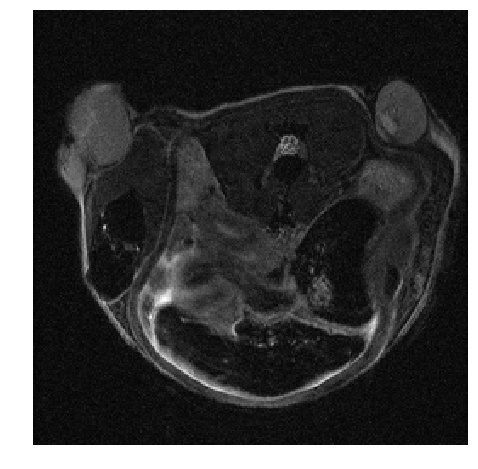

In [3]:
figure(figsize=(8,8))
imshow(t2Slice, origin='lower')
gray()
plt.axis('off')

In [4]:
import scipy.io
cestData = scipy.io.loadmat(save_dir +  'cestData.mat')
cestData = cestData['cestData']

cestDataCorrected = scipy.io.loadmat(save_dir +  'cestDataCorrected.mat')
cestDataCorrected = cestDataCorrected['cestDataCorrected']

cestFreq = scipy.io.loadmat(save_dir +  'cestFreq.mat')
cestFreq = squeeze(cestFreq['cestFreq'])

In [5]:
reload(cxlib)

cestDataCorrectedFilter = cxlib.image_filter(cestDataCorrected,3)

# Z-spectra analysis

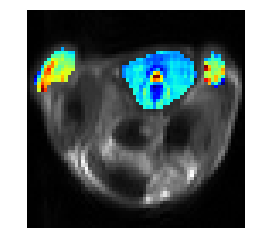

In [6]:
# choose whole tumor
MDA_MB_231_whole = [(53.5, 51.9), (53.03333333333333, 51.833333333333336), (52.633333333333326, 51.1), (51.83333333333333, 50.43333333333333), (51.166666666666664, 49.5), (50.83333333333333, 48.36666666666667), (50.699999999999996, 47.1), (50.633333333333326, 45.36666666666667), (50.96666666666666, 44.166666666666664), (51.83333333333333, 43.03333333333333), (53.5, 42.1), (55.16666666666666, 42.03333333333333), (56.5, 42.63333333333333), (57.099999999999994, 44.1), (57.3, 47.1), (56.633333333333326, 48.96666666666667), (56.36666666666666, 50.1), (55.56666666666666, 50.9), (54.83333333333333, 51.166666666666664), (54.099999999999994, 51.96666666666667)]
MCF_7_whole = [(13.433333333333332, 48.3), (13.433333333333332, 49.233333333333334), (13.03333333333333, 51.5), (11.633333333333331, 51.9), (10.499999999999998, 52.03333333333333), (8.766666666666664, 51.766666666666666), (7.366666666666662, 50.7), (6.366666666666662, 49.9), (4.566666666666663, 47.9), (3.6999999999999975, 45.9), (2.899999999999997, 44.03333333333333), (2.6333333333333293, 42.233333333333334), (3.2333333333333307, 40.5), (4.4999999999999964, 40.3), (5.366666666666662, 40.5), (6.366666666666662, 42.233333333333334), (7.1666666666666625, 43.43333333333333), (8.83333333333333, 43.56666666666666), (10.433333333333332, 43.3), (11.83333333333333, 43.9), (12.499999999999998, 45.1), (13.03333333333333, 46.1), (13.433333333333332, 47.166666666666664)]
Muscle_whole = [(31.699999999999996, 49.9), (30.36666666666666, 49.7), (28.299999999999997, 48.56666666666666), (27.43333333333333, 46.9), (28.166666666666664, 44.63333333333333), (29.233333333333327, 43.03333333333333), (30.566666666666663, 41.166666666666664), (32.49999999999999, 37.96666666666667), (34.03333333333333, 35.43333333333333), (37.36666666666666, 34.63333333333333), (40.89999999999999, 35.63333333333333), (45.166666666666664, 38.233333333333334), (47.89999999999999, 40.9), (49.3, 42.63333333333333), (50.099999999999994, 45.43333333333333), (49.033333333333324, 49.63333333333333), (45.36666666666666, 52.1), (38.83333333333333, 52.166666666666664), (35.03333333333333, 51.63333333333333), (32.76666666666666, 50.56666666666666)]


MDA_MB_231_whole = [(x[0]+0.5, x[1]-0.5) for x in MDA_MB_231_whole]
Muscle_whole = [(x[0]-1, x[1]-1) for x in Muscle_whole]

# get the mask and erosion
MDA_mask_whole = nylib2.roipolyny(cestDataCorrected[0], MDA_MB_231_whole)
MCF_mask_whole = nylib2.roipolyny(cestDataCorrected[0], MCF_7_whole)
muscle_mask_mask = nylib2.roipolyny(cestDataCorrected[0], Muscle_whole)


kernel = np.ones((1,2),np.uint8)
MDA_mask_whole = cv2.erode(MDA_mask_whole,kernel,iterations = 1)
kernel = np.ones((2,2),np.uint8)
muscle_mask_mask = cv2.erode(muscle_mask_mask,kernel,iterations = 1)

# show ROI
imshow(cestData[-1,-1], origin='lower')
gray()

maskedRoi = ma.masked_array(cestData[-1,-1], mask=(MDA_mask_whole==0))
imshow(maskedRoi, origin='lower')
jet()

maskedRoi = ma.masked_array(cestData[-1,-1], mask=(MCF_mask_whole==0))
imshow(maskedRoi, origin='lower')
jet()

maskedRoi = ma.masked_array(cestData[-1,-1], mask=(muscle_mask_mask==0))
imshow(maskedRoi, origin='lower')
jet()

axis('off')

mask_MDA_MB_231 = MDA_mask_whole
mask_MCF_7 = MCF_mask_whole
mask_muscle_backr = muscle_mask_mask

In [7]:
# Z-spectra
pulsePowers = r_[0.3, 0.5, 1.0, 2.0]

data_pulsePowerDependence_masked = zeros((cestDataCorrectedFilter.shape[0], 3, cestDataCorrectedFilter.shape[1]))

for ii in range(len(pulsePowers)):    
    data_pulsePowerDependence_masked[ii, 0] = nylib2.applyMask(cestDataCorrected[ii], mask_MDA_MB_231)   
    data_pulsePowerDependence_masked[ii, 1] = nylib2.applyMask(cestDataCorrected[ii], mask_MCF_7)
    data_pulsePowerDependence_masked[ii, 2] = nylib2.applyMask(cestDataCorrected[ii], mask_muscle_backr)   

# compare different ROIs

/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'S/S$_0$')

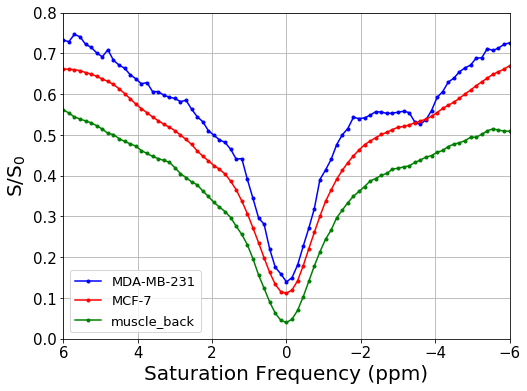

In [8]:
# plot Z-spectra
figure(figsize=(8,6))

# duration time: 1s
# power: 0.3uT, 0.5uT, 1.0uT, 2.0uT, 0.5uT, 1.0uT, 2.0uT
# tag: 0, 1, 2, 3, 4, 5, 6
tag = 3


plot(cestFreq, data_pulsePowerDependence_masked[tag+0,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[tag+0,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[tag+0,2], 'g.-', label='muscle_back')


grid('on')
# ylim(0.8, 1)
# ylim(0.5, 1)
ylim(0, 0.8)
xlim(6,-6)
legend(loc='lower left',fontsize=13)
tick_params(labelsize=15)
xlabel('Saturation Frequency (ppm)',fontsize=20)
ylabel('S/S$_0$',fontsize=20)

Text(0,0.5,'S/S$_0$')

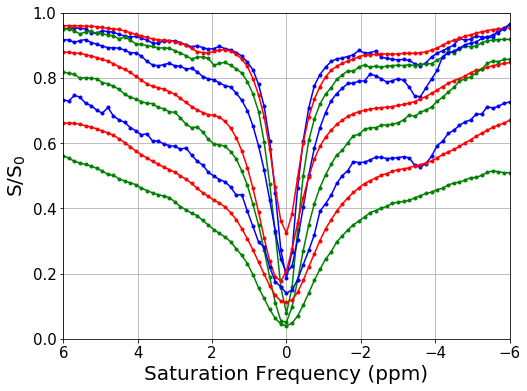

In [9]:
# plot Z-spectra
figure(figsize=(8,6))

# duration time: 1s
# power: 0.3uT, 0.5uT, 1.0uT, 2.0uT, 0.5uT, 1.0uT, 2.0uT
# tag: 0, 1, 2, 3, 4, 5, 6

plot(cestFreq, data_pulsePowerDependence_masked[1,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[1,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[1,2], 'g.-', label='muscle_back')

plot(cestFreq, data_pulsePowerDependence_masked[2,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[2,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[2,2], 'g.-', label='muscle_back')

plot(cestFreq, data_pulsePowerDependence_masked[3,0], 'b.-', label='MDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked[3,1], 'r.-', label='MCF-7')
plot(cestFreq, data_pulsePowerDependence_masked[3,2], 'g.-', label='muscle_back')



grid('on')
ylim(0, 1)
xlim(6,-6)
# legend(loc='lower left',fontsize=13)
tick_params(labelsize=15)
xlabel('Saturation Frequency (ppm)',fontsize=20)
ylabel('S/S$_0$',fontsize=20)

In [10]:
# # save 1s data
# Ztab_MDA_MB_231 = zeros((3, len(cestFreq)))
# Ztab_MDA_MB_231[0] = data_pulsePowerDependence_masked[1,0]
# Ztab_MDA_MB_231[1] = data_pulsePowerDependence_masked[2,0]
# Ztab_MDA_MB_231[2] = data_pulsePowerDependence_masked[3,0]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_Ztab_MDA_MB_231.mat", {'Ztab_MDA_MB_231':Ztab_MDA_MB_231})

# Ztab_MCF_7 = zeros((3, len(cestFreq)))
# Ztab_MCF_7[0] = data_pulsePowerDependence_masked[1,1]
# Ztab_MCF_7[1] = data_pulsePowerDependence_masked[2,1]
# Ztab_MCF_7[2] = data_pulsePowerDependence_masked[3,1]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_Ztab_MCF_7.mat", {'Ztab_MCF_7':Ztab_MCF_7})

# Ztab_Muscle_back = zeros((3, len(cestFreq)))
# Ztab_Muscle_back[0] = data_pulsePowerDependence_masked[1,2]
# Ztab_Muscle_back[1] = data_pulsePowerDependence_masked[2,2]
# Ztab_Muscle_back[2] = data_pulsePowerDependence_masked[3,2]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_Ztab_Muscle_back.mat", {'Ztab_Muscle':Ztab_Muscle_back})


In [11]:
# select frequency
inds_sat = np.nonzero( cestFreq < (cestFreq.max()+1) )[0] 
fitinds = np.hstack((np.where( (cestFreq > 0.01) * (cestFreq < 1.) ),
                        np.where( (cestFreq > -1.) * (cestFreq < -0.01) ),
                        np.where( (cestFreq > cestFreq.max()-1.) )))[0]

In [12]:
reload(cxlib)
reload(cjlib)

lorentz_fitting = zeros((data_pulsePowerDependence_masked.shape[0], data_pulsePowerDependence_masked.shape[1], data_pulsePowerDependence_masked.shape[2]))
lorDiff = zeros((data_pulsePowerDependence_masked.shape[0], data_pulsePowerDependence_masked.shape[1], data_pulsePowerDependence_masked.shape[2]))

for ii in range(data_pulsePowerDependence_masked.shape[0]):
    for ij in range(data_pulsePowerDependence_masked.shape[1]):
        data = data_pulsePowerDependence_masked[ii,ij]
#         newfreq, mm_fixed, lorentz_fitting[ii,ij], At, x0t, wt, bt, kt = cjlib.cestFit( cestFreq[inds_sat], data[inds_sat], fitinds, cestFreq[inds_sat])
        lorentz_fitting[ii, ij]  = cxlib.freqDomainShift(cestFreq, data)[0]
        lorDiff[ii,ij] = lorentz_fitting[ii,ij] - data

MTRasym =  zeros((data_pulsePowerDependence_masked.shape[0], data_pulsePowerDependence_masked.shape[1], (data_pulsePowerDependence_masked.shape[2]-1)/2))
for ii in range(data_pulsePowerDependence_masked.shape[0]):
    for ij in range(data_pulsePowerDependence_masked.shape[1]):
        data = data_pulsePowerDependence_masked[ii,ij]
        asymFreq, MTRasym[ii,ij] = cxlib.asymAnalysis(cestFreq, data)

In [13]:
# # save 1s data
# LD_MDA_MB_231 = zeros((3, len(cestFreq)))
# LD_MDA_MB_231[0] = lorDiff[1,0]
# LD_MDA_MB_231[1] = lorDiff[2,0]
# LD_MDA_MB_231[2] = lorDiff[3,0]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_LD_MDA_MB_231.mat", {'LD_MDA_MB_231':LD_MDA_MB_231})

# LD_MCF_7 = zeros((3, len(cestFreq)))
# LD_MCF_7[0] = lorDiff[1,1]
# LD_MCF_7[1] = lorDiff[2,1]
# LD_MCF_7[2] = lorDiff[3,1]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_LD_MCF_7.mat", {'LD_MCF_7':LD_MCF_7})

# LD_Muscle_back = zeros((3, len(cestFreq)))
# LD_Muscle_back[0] = lorDiff[1,2]
# LD_Muscle_back[1] = lorDiff[2,2]
# LD_Muscle_back[2] = lorDiff[3,2]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_LD_Muscle_back.mat", {'LD_Muscle':LD_Muscle_back})


# # save 1s data
# MTR_MDA_MB_231 = zeros((3, len(asymFreq)))
# MTR_MDA_MB_231[0] = MTRasym[1,0]
# MTR_MDA_MB_231[1] = MTRasym[2,0]
# MTR_MDA_MB_231[2] = MTRasym[3,0]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_MTR_MDA_MB_231.mat", {'MTR_MDA_MB_231':MTR_MDA_MB_231})

# MTR_MCF_7 = zeros((3, len(asymFreq)))
# MTR_MCF_7[0] = MTRasym[1,1]
# MTR_MCF_7[1] = MTRasym[2,1]
# MTR_MCF_7[2] = MTRasym[3,1]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_MTR_MCF_7.mat", {'MTR_MCF_7':MTR_MCF_7})

# MTR_Muscle_back = zeros((3, len(asymFreq)))
# MTR_Muscle_back[0] = MTRasym[1,2]
# MTR_Muscle_back[1] = MTRasym[2,2]
# MTR_Muscle_back[2] = MTRasym[3,2]
# from scipy.io import savemat
# savemat(save_dir + mouse + "_MTR_Muscle_back.mat", {'MTR_Muscle_back':MTR_Muscle_back})


# from scipy.io import savemat
# savemat(save_dir + "MTRasym_offset.mat", {'asymFreq':asymFreq})


([<matplotlib.axis.XTick at 0x7fdd94932210>,
 <a list of 7 Text xticklabel objects>)

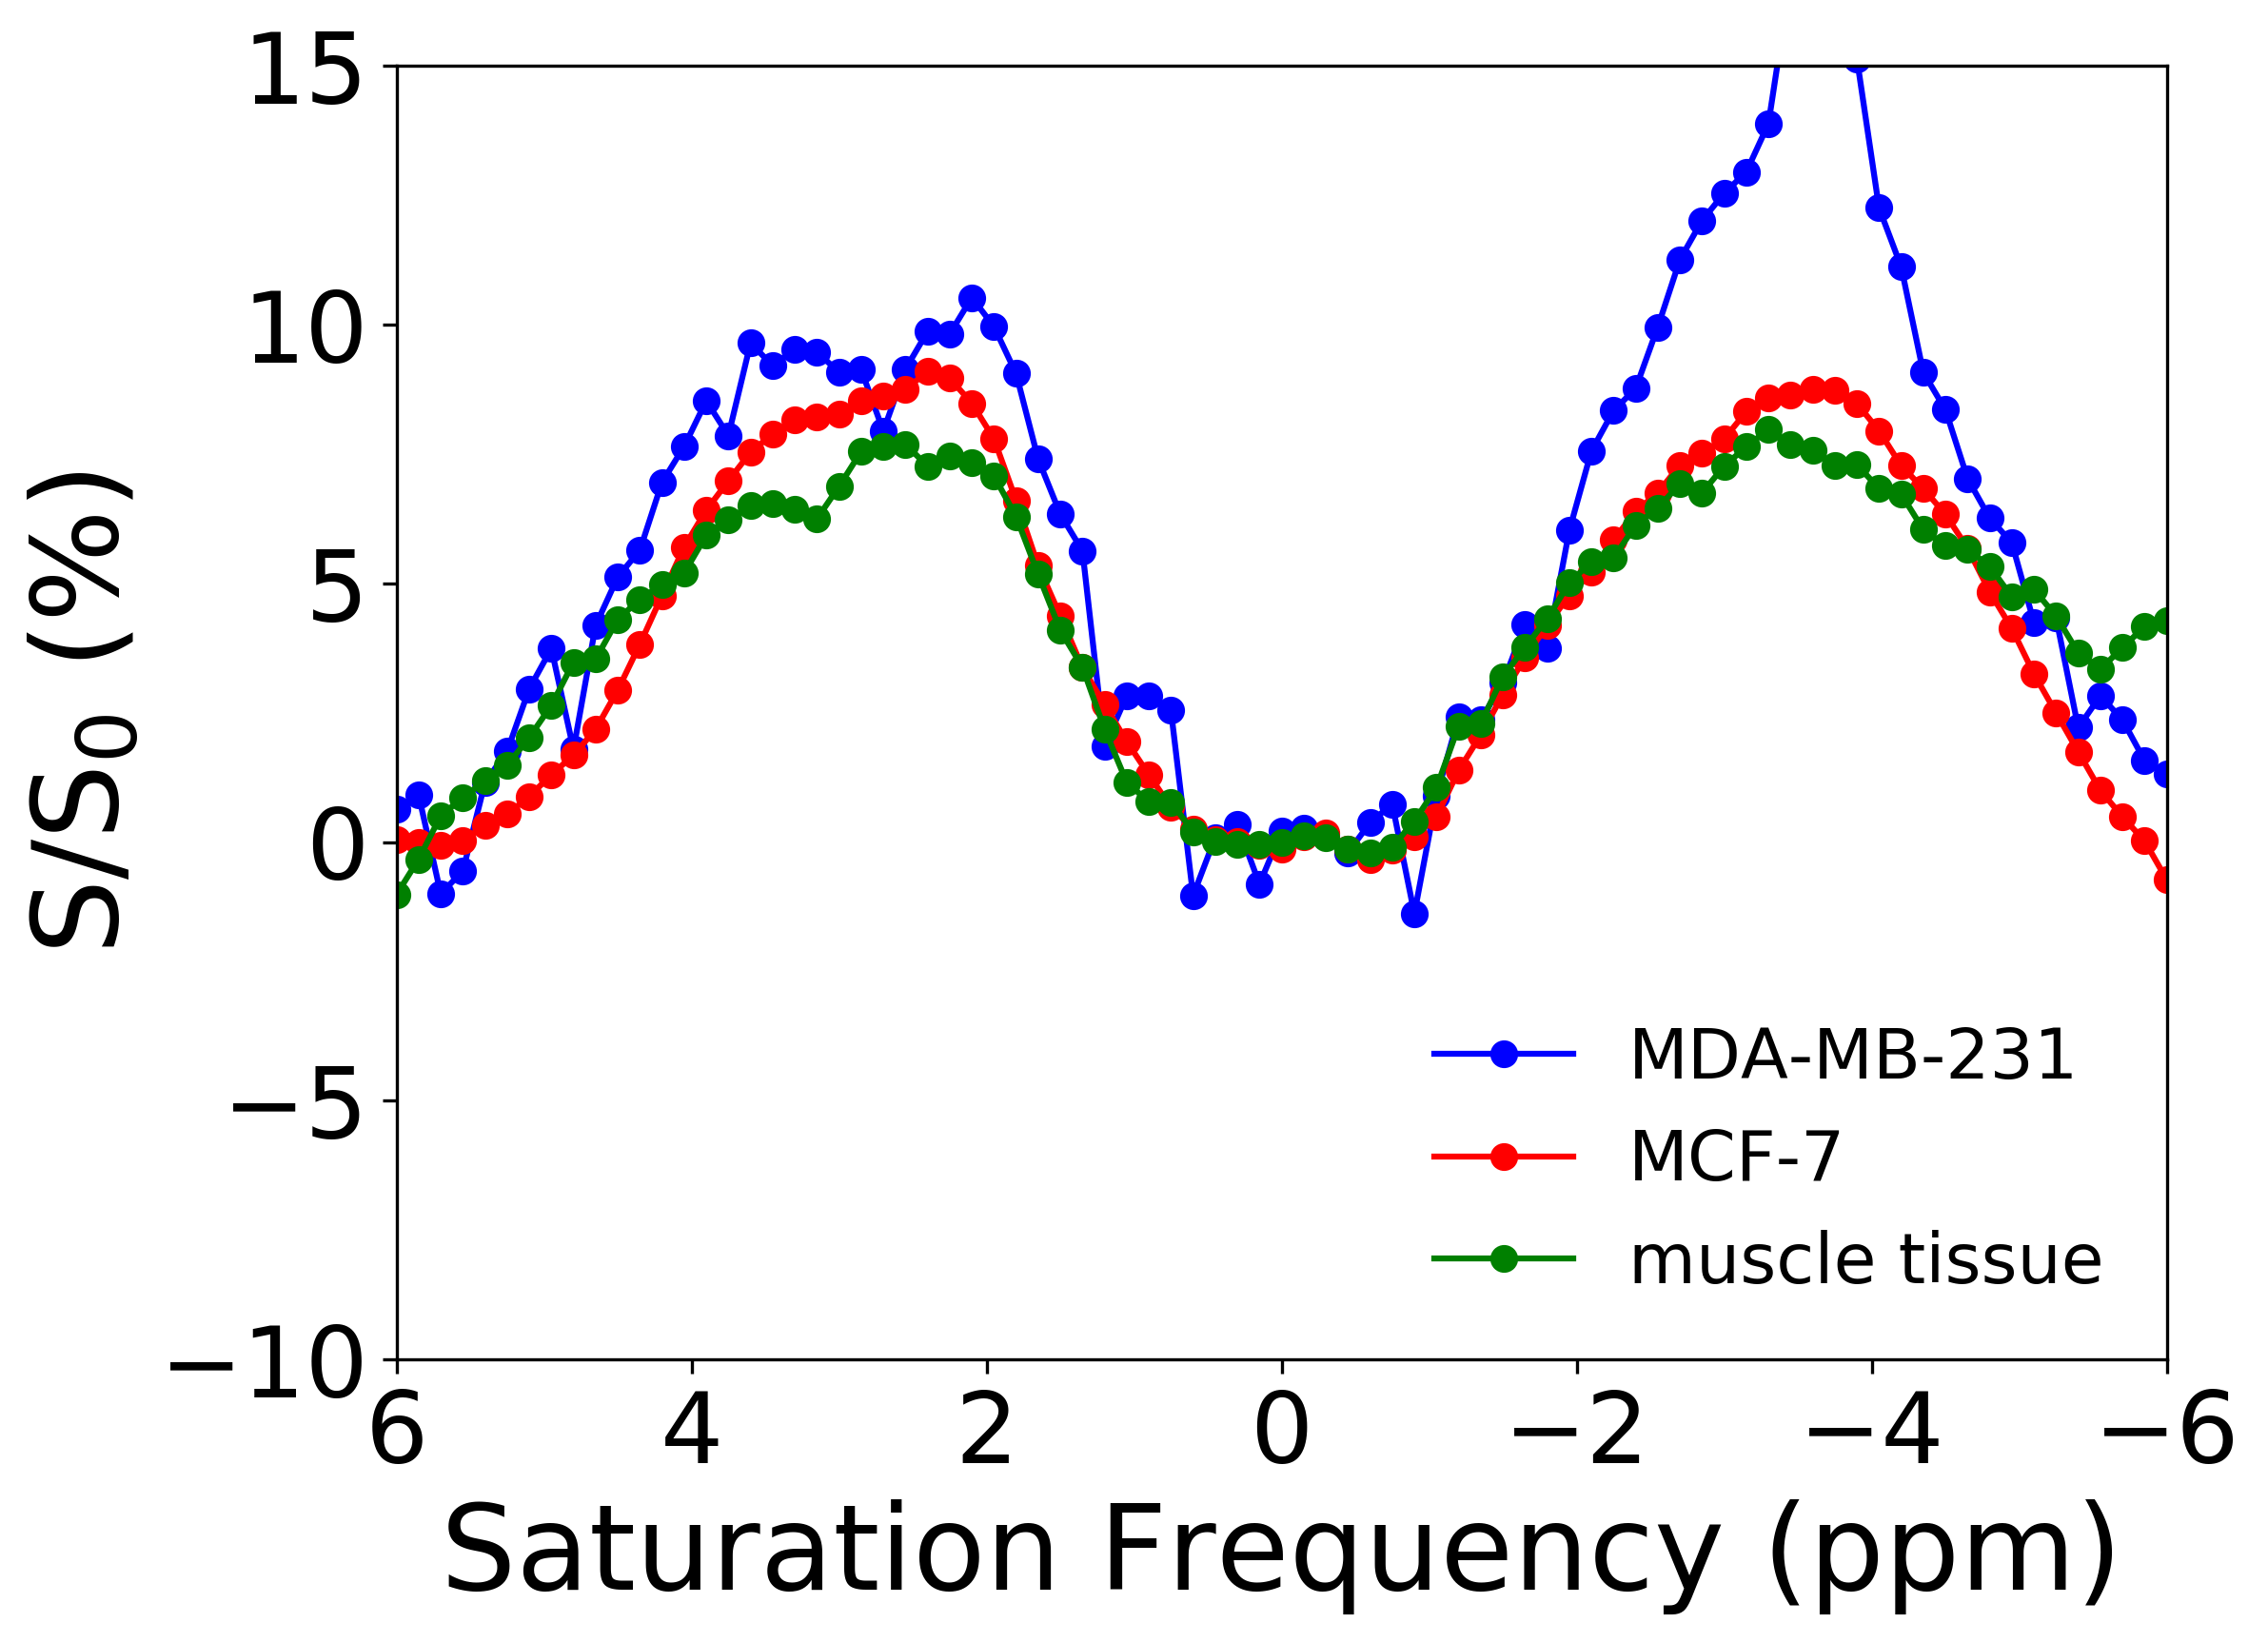

In [14]:
# figure(figsize=(8,6))
figure(figsize=(8,6),dpi=300)
# subplot(121)
# title('0.5uT 4th mouse double tumor')
tag = 3
plot(cestFreq, lorDiff[tag,0]*100, 'bo-', label='MDA-MB-231')
plot(cestFreq, lorDiff[tag,1]*100, 'ro-', label='MCF-7')
plot(cestFreq, lorDiff[tag,2]*100, 'go-', label='muscle tissue')

ylim(-10, 15)
xlim(6,-6)
tick_params(labelsize=25)
legend(loc='lower right',frameon=False, fontsize=17.5)
xlabel('Saturation Frequency (ppm)',fontsize=30)
# xlabel(u'\u0394'+u'\u03C9',fontsize=15)
ylabel('S/S$_0$ (%)',fontsize=30)
xticks([6, 4, 2, 0, -2, -4, -6])

([<matplotlib.axis.XTick at 0x7fdd947afd10>,
 <a list of 7 Text xticklabel objects>)

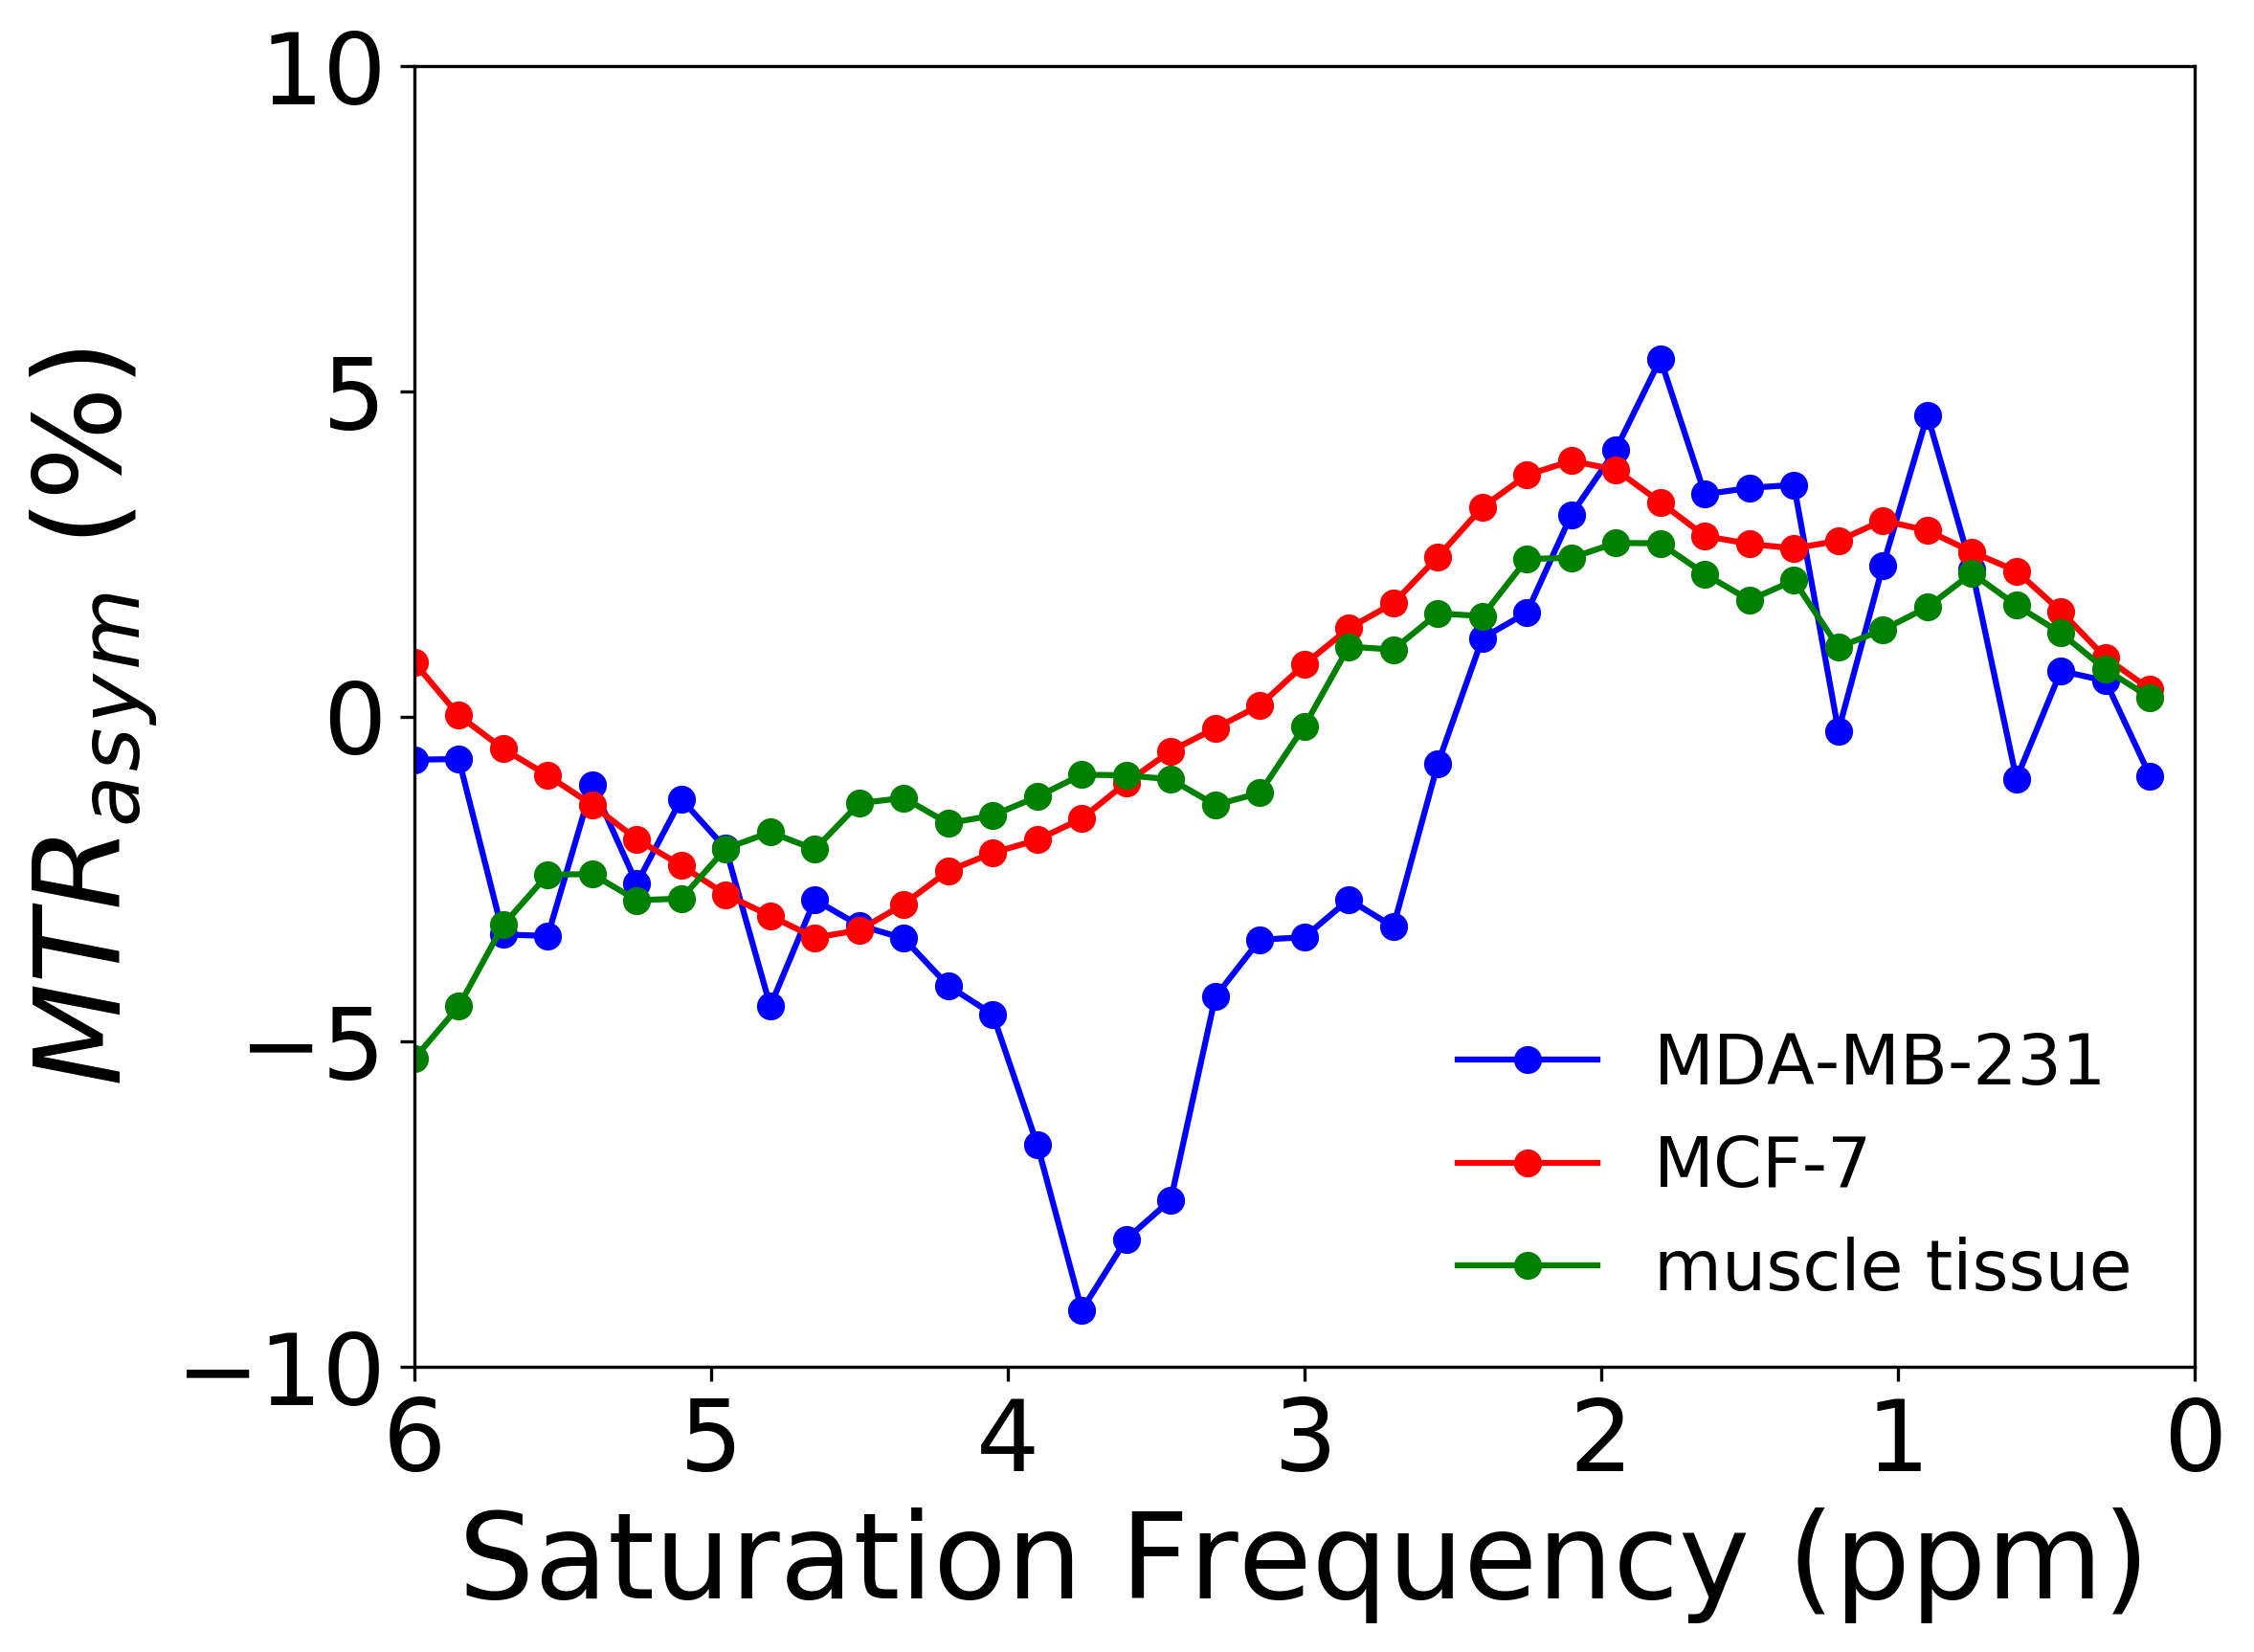

In [15]:
# figure(figsize=(8,6))
figure(figsize=(8,6),dpi=300)
# subplot(121)
# title('0.5uT 4th mouse double tumor')

plot(asymFreq, MTRasym[tag,0]*100, 'bo-', label='MDA-MB-231')
plot(asymFreq, MTRasym[tag,1]*100, 'ro-', label='MCF-7')
plot(asymFreq, MTRasym[tag,2]*100, 'go-', label='muscle tissue')

ylim(-10, 10)
xlim(6,0)
tick_params(labelsize=25)
legend(loc='lower right',frameon=False, fontsize=17.5)
xlabel('Saturation Frequency (ppm)',fontsize=30)
# xlabel(u'\u0394'+u'\u03C9',fontsize=15)
ylabel('${MTR_a}{_s}{_y}{_m}$ (%)',fontsize=30)
xticks([6, 5, 4, 3, 2, 1, 0])

In [16]:
mask1 = np.ma.mask_or(MDA_mask_whole, MCF_mask_whole)
mask2 = np.ma.mask_or(MCF_mask_whole, muscle_mask_mask)
mask = np.ma.mask_or(mask1, mask2)

In [17]:
reload(cxlib)
highFreq = 6.1
lowFreq = -6.1
Data = cestDataCorrected[3]
LDcest, indsFreq = cxlib.LDMap(cestFreq, Data, lowFreq, highFreq)
asym, asymFreq = cxlib.asymMap(cestFreq, Data, lowFreq, highFreq)

/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


In [18]:
def CEST_Avg(cestData, indsFreq, beginFreq, endFreq):
    Inds = where((indsFreq>=beginFreq) & (indsFreq<=endFreq))
    cest_Avg = zeros((cestData.shape[1],cestData.shape[2]))
   
    for ii in Inds[0]:
        cest_Avg = add(cest_Avg, cestData[ii])
    cest_Avg  = cest_Avg / len(Inds[0])
    return cest_Avg

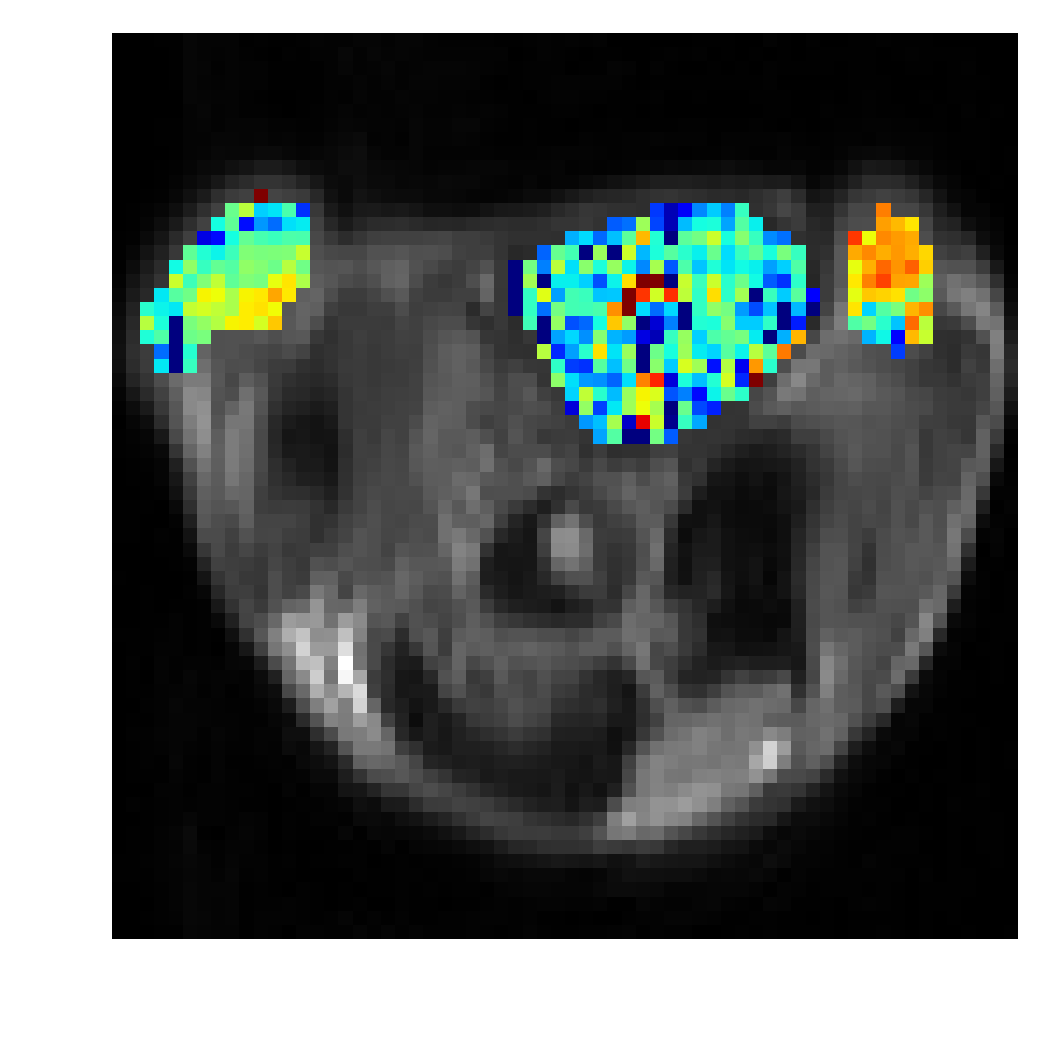

In [19]:
# show LD map at 2, 3.5, 4 ppm
import os,sys
scriptpath = "/Users/cbie1/Documents/pythonLibrary/colormap-master/"
sys.path.append(os.path.abspath(scriptpath))
import colormaps as cmaps


lLim = 0.0
hLim = 0.15

# beginFreq = 1.9
# endFreq = 1.95

beginFreq = 3.5
endFreq = 3.6

# beginFreq = 4.
# endFreq = 4.1


cest_LD_Avg = CEST_Avg(LDcest, indsFreq, beginFreq, endFreq)

# fig, ax = plt.subplots()
fig, ax = plt.subplots(dpi=300)

cax = plt.imshow(cestData[1,-1],origin='lower', cmap='gray')

maskedRoi = ma.masked_array(cest_LD_Avg, mask=(mask==0))
cax = plt.imshow(maskedRoi, origin='lower')
jet()

plt.axis('off')
plt.clim(lLim, hLim)

# cbar = fig.colorbar(cax, ticks=[0., 0.05, 0.10, 0.15])
# cbar.ax.set_yticklabels(['0%', '5%', '10%', '15%'],fontsize=20) 

[Text(1,0,'0%'),
 Text(1,0,'5%'),
 Text(1,0,'10%'),
 Text(1,0,'15%'),
 Text(1,0,'20%')]

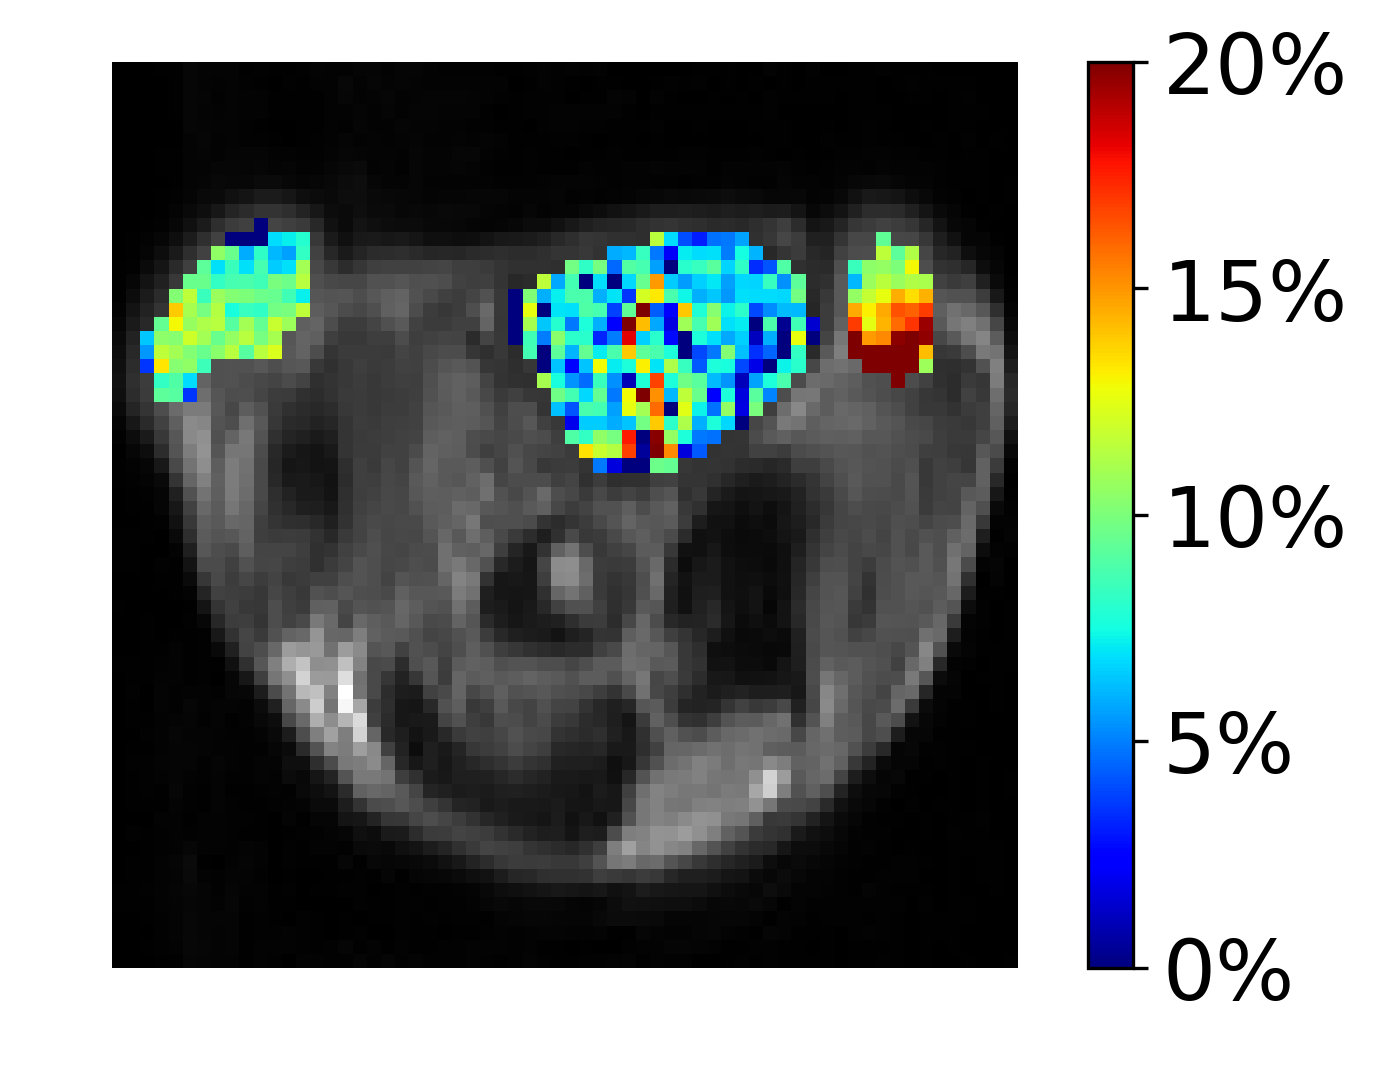

In [20]:
###### show LD map at -3.5ppm
lLim = 0
hLim = 0.2

beginFreq = -3.5
endFreq = -3.4

cest_LD_Avg = CEST_Avg(LDcest, indsFreq, beginFreq, endFreq)

fig, ax = plt.subplots(dpi=300)

cax = imshow(cestData[1,-1])
gray()
maskedRoi = ma.masked_array(cest_LD_Avg, mask=(mask==0))
cax = imshow(maskedRoi, origin='lower')
jet()

plt.axis('off')
plt.clim(lLim, hLim)

cbar = fig.colorbar(cax, ticks=[0., 0.05, 0.1, 0.15, 0.20])
cbar.ax.set_yticklabels(['0%', '5%', '10%', '15%','20%'],fontsize=20) 

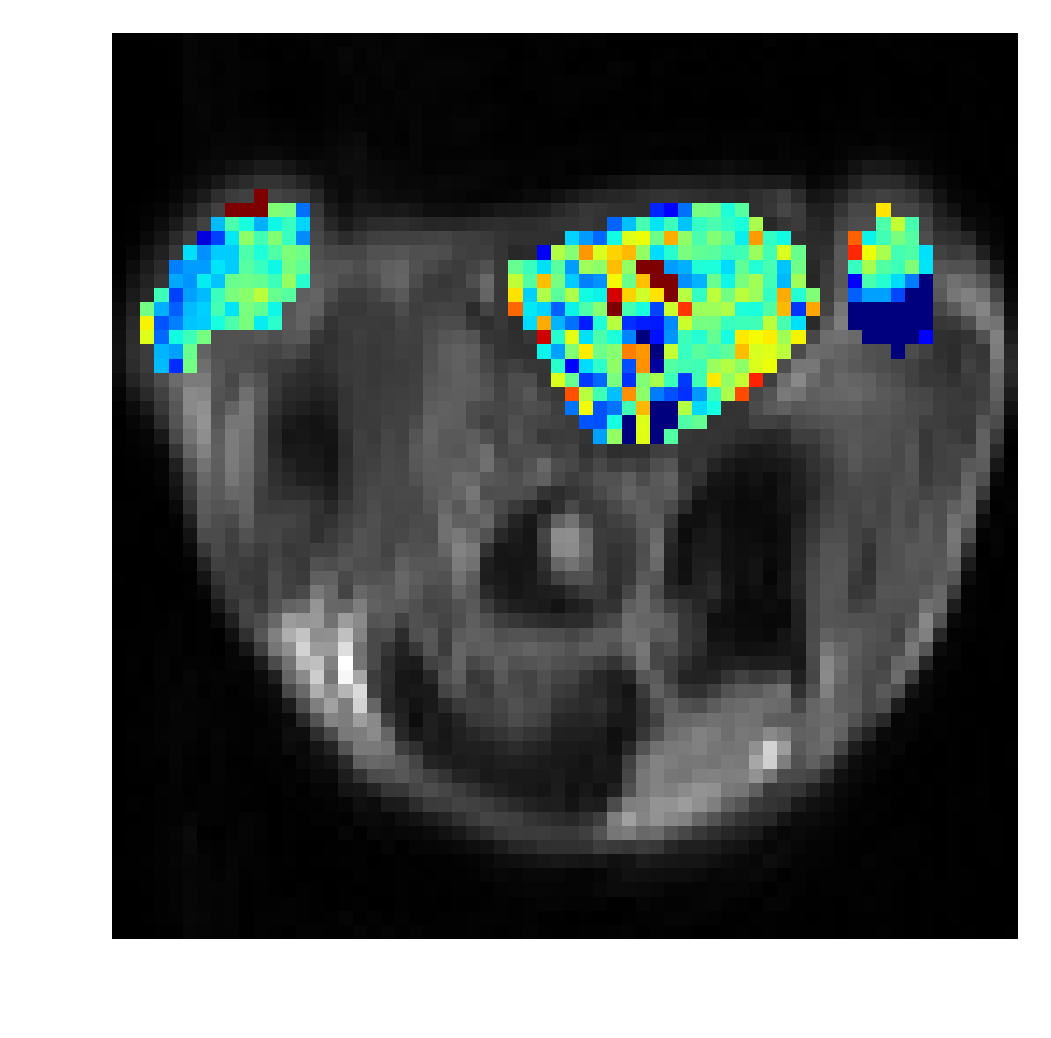

In [21]:
# show MTRasym map at 2, 3.5, 4 ppm
lLim = -0.1
hLim = 0.1


# beginFreq = 1.9
# endFreq = 1.95


beginFreq = 3.5
endFreq = 3.6

# beginFreq = 4.
# endFreq = 4.1



cest_asym_Avg = CEST_Avg(asym, asymFreq, beginFreq, endFreq)

fig, ax = plt.subplots(dpi=300)

cax = imshow(cestData[1,-1])
gray()
maskedRoi = ma.masked_array(cest_asym_Avg, mask=(mask==0))
cax = imshow(maskedRoi, origin='lower')
jet()

plt.axis('off')
plt.clim(lLim, hLim)


# cbar = fig.colorbar(cax, ticks=[-0.1, -0.05,  0, 0.05, 0.1])
# cbar.ax.set_yticklabels(['-10%', '-5%', '0%', '5%', '10%'], fontsize=20) 


# PCA-based denoising and save

In [22]:
# tumor
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Data_Right_Tumor = []
for ii in range(MDA_mask_whole.shape[0]):
    for ij in range(MDA_mask_whole.shape[1]):
        if MDA_mask_whole[ii, ij] == True:
            Data_Right_Tumor.append(cestDataCorrectedFilter[1, :, ii, ij])
Data_Right_Tumor = array(Data_Right_Tumor)
Index_Right_Tumor = zeros((Data_Right_Tumor.shape[0]))
# Data_Right_Tumor_PCA, eigen_value, var = cxlib.PCA_denoising(Data_Right_Tumor,3,8)

In [23]:
# tumor
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Data_Left_Tumor = []
for ii in range(MCF_mask_whole.shape[0]):
    for ij in range(MCF_mask_whole.shape[1]):
        if MCF_mask_whole[ii, ij] == True:
            Data_Left_Tumor.append(cestDataCorrectedFilter[1, :, ii, ij])
Data_Left_Tumor = array(Data_Left_Tumor)
Index_Left_Tumor = zeros((Data_Left_Tumor.shape[0]))+1
# Data_Left_Tumor_PCA, eigen_value, var = cxlib.PCA_denoising(Data_Left_Tumor,3,10)

In [24]:
# tumor
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

Data_Tissue = []
for ii in range(muscle_mask_mask.shape[0]):
    for ij in range(muscle_mask_mask.shape[1]):
        if muscle_mask_mask[ii, ij] == True:
            Data_Tissue.append(cestDataCorrectedFilter[1, :, ii, ij])
Data_Tissue = array(Data_Tissue)
Index_Tissue = zeros((Data_Tissue.shape[0]))+2
# Data_Tissue_PCA, eigen_value, var = cxlib.PCA_denoising(Data_Tissue,3,10)

In [25]:
Data_cest = []
Data_cest += list(Data_Right_Tumor)
Data_cest += list(Data_Left_Tumor)
Data_cest += list(Data_Tissue)
Data_cest = array(Data_cest)

Index =[]
Index += list(Index_Right_Tumor)
Index += list(Index_Left_Tumor)
Index += list(Index_Tissue)
Index = array(Index)

In [26]:
# numpy.savetxt(save_dir + mouse + 'whole_sep_0pt5_filter.csv', Data_cest, delimiter = ',')
# # numpy.savetxt(save_dir + mouse + 'whole_sep_2pt_denoising_filter.csv', Data_cest_PCA, delimiter = ',')

# data = Data_cest
# data_PCA, eigen_value, var = cxlib.PCA_denoising(data,3,98)
# numpy.savetxt(save_dir + mouse + 'whole_sep_0pt5_denoising_filter.csv', data_PCA, delimiter = ',')

# numpy.savetxt(save_dir + mouse + 'whole_sep_0pt5_denoising_filter_index.csv', Index, delimiter = ',')

In [27]:
# save_dir = '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20200824/M1_3/'

Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2+1uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2+1+05uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2+05uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_1+05uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_1uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_05uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_uneven_2uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_uniform_2uT_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_LD_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_LD_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_MTR_1.csv', delimiter = ',')

# Pred_cnn = np.loadtxt(save_dir + mouse + '_pred_sep_knn_2uT_LD_MTR_1.csv', delimiter = ',')

right_Tumor_Pred_cnn = Pred_cnn[0:len(Data_Right_Tumor)]
left_Tumor_Pred_cnn = Pred_cnn[len(Data_Right_Tumor): len(Data_Right_Tumor)+len(Data_Left_Tumor)]
tissue_Pred_cnn = Pred_cnn[len(Data_Right_Tumor)+len(Data_Left_Tumor):]

map_Pred_Right_Tumor_cnn = zeros((MDA_mask_whole.shape[0], MDA_mask_whole.shape[1]))
map_Pred_Right_False_Left_Tumor_cnn = zeros((MDA_mask_whole.shape[0], MDA_mask_whole.shape[1]))
map_Pred_Right_False_Tissue_Tumor_cnn = zeros((MDA_mask_whole.shape[0], MDA_mask_whole.shape[1]))

map_Pred_Left_Tumor_cnn = zeros((MCF_mask_whole.shape[0], MCF_mask_whole.shape[1]))
map_Pred_Left_False_Right_Tumor_cnn = zeros((MCF_mask_whole.shape[0], MCF_mask_whole.shape[1]))
map_Pred_Left_False_Tissue_Tumor_cnn = zeros((MCF_mask_whole.shape[0], MCF_mask_whole.shape[1]))

map_Pred_Tissue_cnn = zeros((muscle_mask_mask.shape[0], muscle_mask_mask.shape[1]))
map_Pred_Tissue_False_Right_Tumor_cnn = zeros((muscle_mask_mask.shape[0], muscle_mask_mask.shape[1]))
map_Pred_Tissue_False_Left_Tumor_cnn = zeros((muscle_mask_mask.shape[0], muscle_mask_mask.shape[1]))


count = 0
for ii in range(MDA_mask_whole.shape[0]):
    for ij in range(MDA_mask_whole.shape[1]):
        if MDA_mask_whole[ii, ij] == 1:
            if right_Tumor_Pred_cnn[count] == 0:
                map_Pred_Right_Tumor_cnn[ii, ij] = 1
            elif right_Tumor_Pred_cnn[count] == 1:
                map_Pred_Right_False_Left_Tumor_cnn[ii, ij] = 1
            elif right_Tumor_Pred_cnn[count] == 2:
                map_Pred_Right_False_Tissue_Tumor_cnn[ii, ij] = 1
            count = count + 1
        
count = 0
for ii in range(MCF_mask_whole.shape[0]):
    for ij in range(MCF_mask_whole.shape[1]):
        if MCF_mask_whole[ii, ij] == 1:
            if left_Tumor_Pred_cnn[count] == 1:
                map_Pred_Left_Tumor_cnn[ii, ij] = 1
            elif left_Tumor_Pred_cnn[count] == 0:
                map_Pred_Left_False_Right_Tumor_cnn[ii, ij] = 1
            elif left_Tumor_Pred_cnn[count] == 2:
                map_Pred_Left_False_Tissue_Tumor_cnn[ii, ij] = 1
            count = count + 1
            
            
count = 0
for ii in range(muscle_mask_mask.shape[0]):
    for ij in range(muscle_mask_mask.shape[1]):
        if muscle_mask_mask[ii, ij] == 1:
            if tissue_Pred_cnn[count] == 2:
                map_Pred_Tissue_cnn[ii, ij] = 1
            elif tissue_Pred_cnn[count] == 0:
                map_Pred_Tissue_False_Right_Tumor_cnn[ii, ij] = 1
            elif tissue_Pred_cnn[count] == 1:
                map_Pred_Tissue_False_Left_Tumor_cnn[ii, ij] = 1
            count = count + 1

(-0.5, 63.5, -0.5, 63.5)

/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/image.py:413: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/image.py:418: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/cbie1/opt/anaconda2/envs/python2/lib/python2.7/site-packages/numpy/ma/core.p

<Figure size 864x432 with 0 Axes>

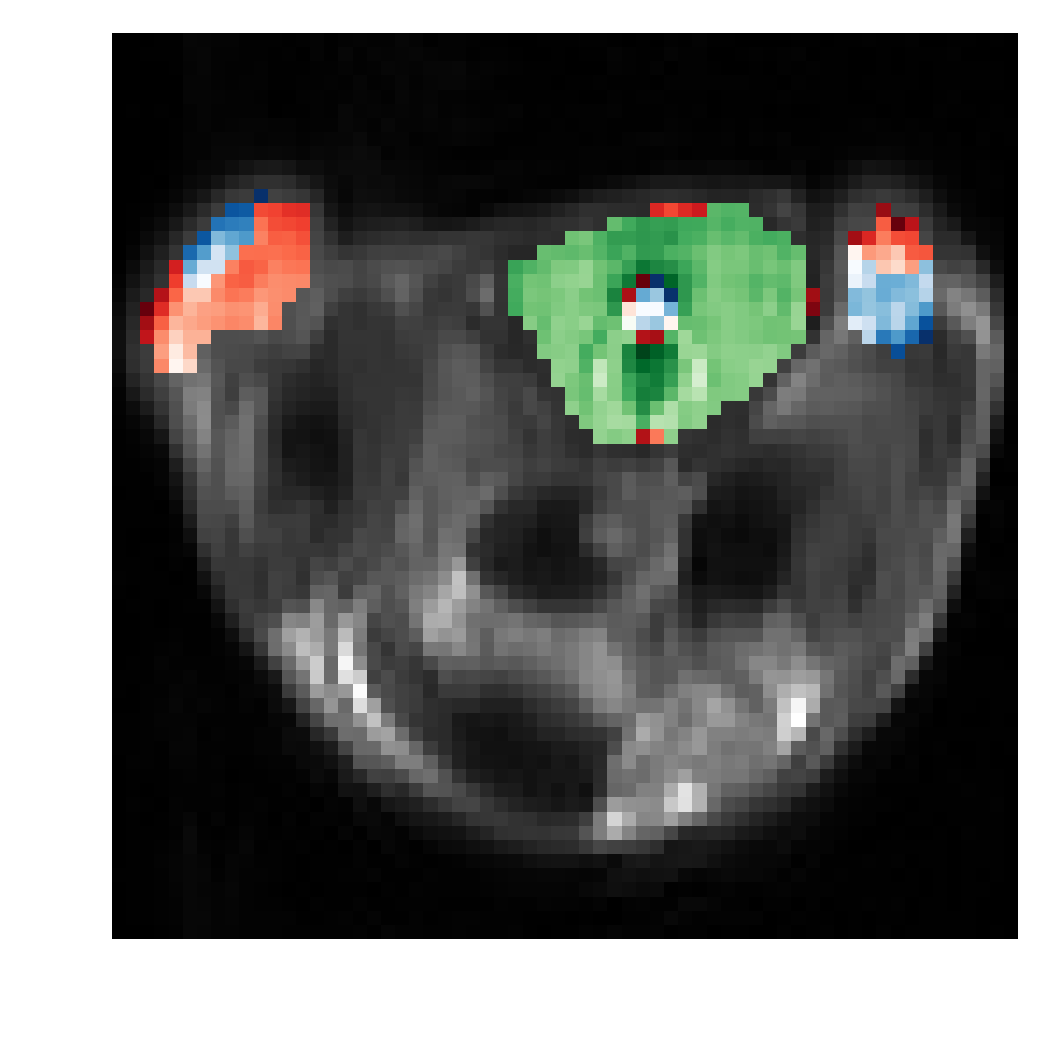

In [28]:
from matplotlib import colors
figure(figsize=(12,6))
figure(dpi=300)
imshow(cestData[3,-1], origin = 'lower')
gray()
# plt.clim(0, 1)
# plt.colorbar()
# cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Right_Tumor_cnn==0))
imshow(maskedRoi, cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Right_False_Left_Tumor_cnn==0))
imshow(maskedRoi,cmap='Reds_r', origin = 'lower')

cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Right_False_Tissue_Tumor_cnn==0))
imshow(maskedRoi,cmap='Greens_r', origin = 'lower')

#---------------------------------------------------
cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Left_Tumor_cnn==0))
imshow(maskedRoi,cmap='Reds_r', origin = 'lower')

cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Left_False_Right_Tumor_cnn==0))
imshow(maskedRoi, cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[1,-1], mask=(map_Pred_Left_False_Tissue_Tumor_cnn==0))
imshow(maskedRoi,cmap='Greens_r', origin = 'lower')

#---------------------------------------------------
cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Tissue_cnn==0))
imshow(maskedRoi,cmap='Greens_r', origin = 'lower')

cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Tissue_False_Right_Tumor_cnn==0))
imshow(maskedRoi, cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Tissue_False_Left_Tumor_cnn==0))
imshow(maskedRoi,cmap='Reds_r', origin = 'lower')

axis('off')

In [286]:
test_roi0 = [(7.633333333333331, 50.5), (6.633333333333331, 49.7), (5.633333333333331, 48.7), (4.233333333333331, 47.233333333333334), (4.4999999999999964, 45.766666666666666), (5.966666666666663, 45.7), (7.099999999999996, 46.36666666666667), (8.233333333333329, 47.1), (9.299999999999995, 48.5), (9.499999999999998, 49.43333333333333), (8.566666666666665, 50.36666666666667)]
test_roi1 = [(56.3, 47.766666666666666), (55.633333333333326, 47.7), (54.5, 47.7), (53.03333333333333, 47.63333333333333), (52.23333333333333, 47.1), (52.099999999999994, 46.1), (52.3, 45.43333333333333), (53.233333333333334, 45.03333333333333), (54.16666666666666, 44.96666666666667), (55.099999999999994, 44.96666666666667), (56.099999999999994, 45.766666666666666), (56.3, 46.43333333333333), (56.43333333333332, 47.43333333333333)]
# [(54.83333333333333, 46.63333333333333), (53.89999999999999, 46.766666666666666), (52.89999999999999, 46.36666666666667), (52.43333333333333, 44.5), (52.83333333333333, 43.43333333333333), (53.83333333333333, 43.233333333333334), (54.89999999999999, 43.63333333333333), (55.69999999999999, 44.9), (54.966666666666654, 46.833333333333336)]
# [(56.099999999999994, 50.833333333333336), (55.69999999999999, 51.833333333333336), (54.03333333333333, 52.5), (53.43333333333332, 51.96666666666667), (52.89999999999999, 50.833333333333336), (52.89999999999999, 49.36666666666667), (53.099999999999994, 48.233333333333334), (53.766666666666666, 47.36666666666667), (54.5, 47.3), (55.5, 47.7), (55.89999999999999, 48.766666666666666), (56.3, 49.56666666666666)]

# test_roi0 = [(x[0]-2, x[1]-2) for x in test_roi0]
test_roi1 = [(x[0]-0.5, x[1]+2.5) for x in test_roi1]
# test_roi1 = [(x[0]-0, x[1]-1.5) for x in test_roi1]


test0_mask = nylib2.roipolyny(cestDataCorrected[0], test_roi0)
test1_mask = nylib2.roipolyny(cestDataCorrected[0], test_roi1)

kernel = np.ones((1,1),np.uint8)
# test0_mask = cv2.erode(test0_mask,kernel,iterations = 1)
# test1_mask = cv2.erode(test1_mask,kernel,iterations = 1)
# test2_mask = cv2.erode(test2_mask,kernel,iterations = 1)

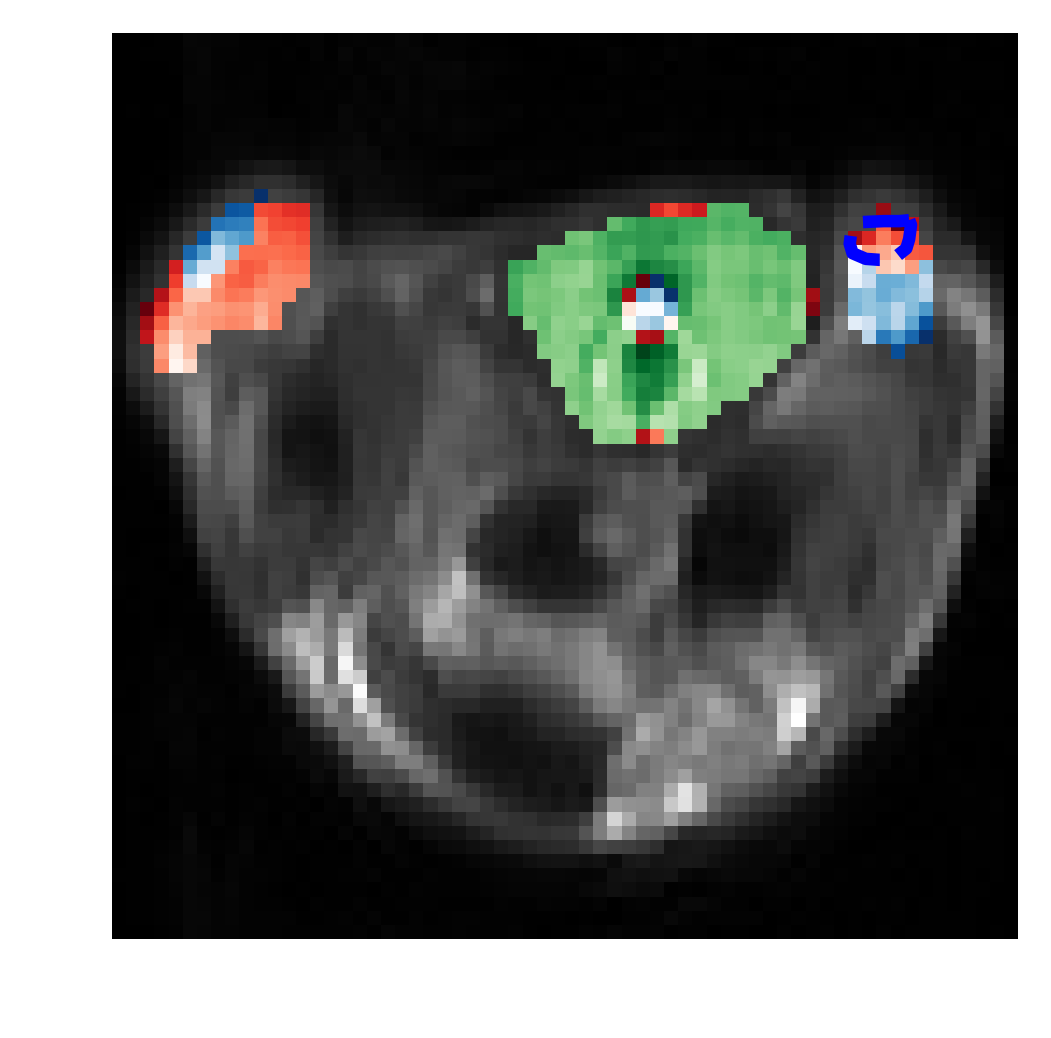

In [287]:
from matplotlib import colors
# figure(figsize=(12,6))
# figure(figsize=(12,6))
figure(dpi=300)
imshow(cestData[3,-1], origin = 'lower')
gray()
# plt.clim(0, 1)
# plt.colorbar()
# cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Right_Tumor_cnn==0))
imshow(maskedRoi, cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Right_False_Left_Tumor_cnn==0))
imshow(maskedRoi,cmap='Reds_r', origin = 'lower')

cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Right_False_Tissue_Tumor_cnn==0))
imshow(maskedRoi,cmap='Greens_r', origin = 'lower')

#---------------------------------------------------
cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Left_Tumor_cnn==0))
imshow(maskedRoi,cmap='Reds_r', origin = 'lower')

cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Left_False_Right_Tumor_cnn==0))
imshow(maskedRoi, cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[1,-1], mask=(map_Pred_Left_False_Tissue_Tumor_cnn==0))
imshow(maskedRoi,cmap='Greens_r', origin = 'lower')

#---------------------------------------------------
cmap = colors.ListedColormap(['green'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Tissue_cnn==0))
imshow(maskedRoi,cmap='Greens_r', origin = 'lower')

cmap = colors.ListedColormap(['blue'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Tissue_False_Right_Tumor_cnn==0))
imshow(maskedRoi, cmap='Blues_r', origin = 'lower')

cmap = colors.ListedColormap(['red'])
maskedRoi = ma.masked_array(cestData[3,-1], mask=(map_Pred_Tissue_False_Left_Tumor_cnn==0))
imshow(maskedRoi,cmap='Reds_r', origin = 'lower')

axis('off')


# XY = test_roi0
# XY=np.array(XY)
# XY = np.concatenate ((XY, [XY[0,:]]), axis=0 )
# plot(XY.transpose()[0], XY.transpose()[1], '--', color='darkred', linewidth = 3)
# figure(1).canvas.draw()

XY = test_roi1
XY=np.array(XY)
XY = np.concatenate ((XY, [XY[0,:]]), axis=0 )
plot(XY.transpose()[0], XY.transpose()[1], '--',color='blue', linewidth = 3)
figure(1).canvas.draw()


In [288]:
# Z-spectra
pulsePowers = r_[0.3,0.5, 1.0, 2.0]

data_pulsePowerDependence_masked_test = zeros((cestDataCorrected.shape[0], 2, cestDataCorrected.shape[1]))

for ii in range(len(pulsePowers)):    
    data_pulsePowerDependence_masked_test[ii, 0] = nylib2.applyMask(cestDataCorrectedFilter[ii], test0_mask)
    data_pulsePowerDependence_masked_test[ii, 1] = nylib2.applyMask(cestDataCorrectedFilter[ii], test1_mask)

In [292]:
import scipy.io

path3 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M3-2/'
invivo_MDA231_3_o = scipy.io.loadmat(path3 +  'M3_2_Ztab_MDA_MB_231_ref.mat')
invivo_MDA231_3_o = invivo_MDA231_3_o['Ztab_MDA_MB_231']
invivo_MCF7_3_o = scipy.io.loadmat(path3 +  'M3_2_Ztab_MCF_7_ref.mat')
invivo_MCF7_3_o = invivo_MCF7_3_o['Ztab_MCF_7']
invivo_muscle_3_o = scipy.io.loadmat(path3 +  'M3_2_Ztab_muscle_back_ref.mat')
invivo_muscle_3_o = invivo_muscle_3_o['Ztab_Muscle']


([<matplotlib.axis.XTick at 0x7fc752dae050>,
 <a list of 7 Text xticklabel objects>)

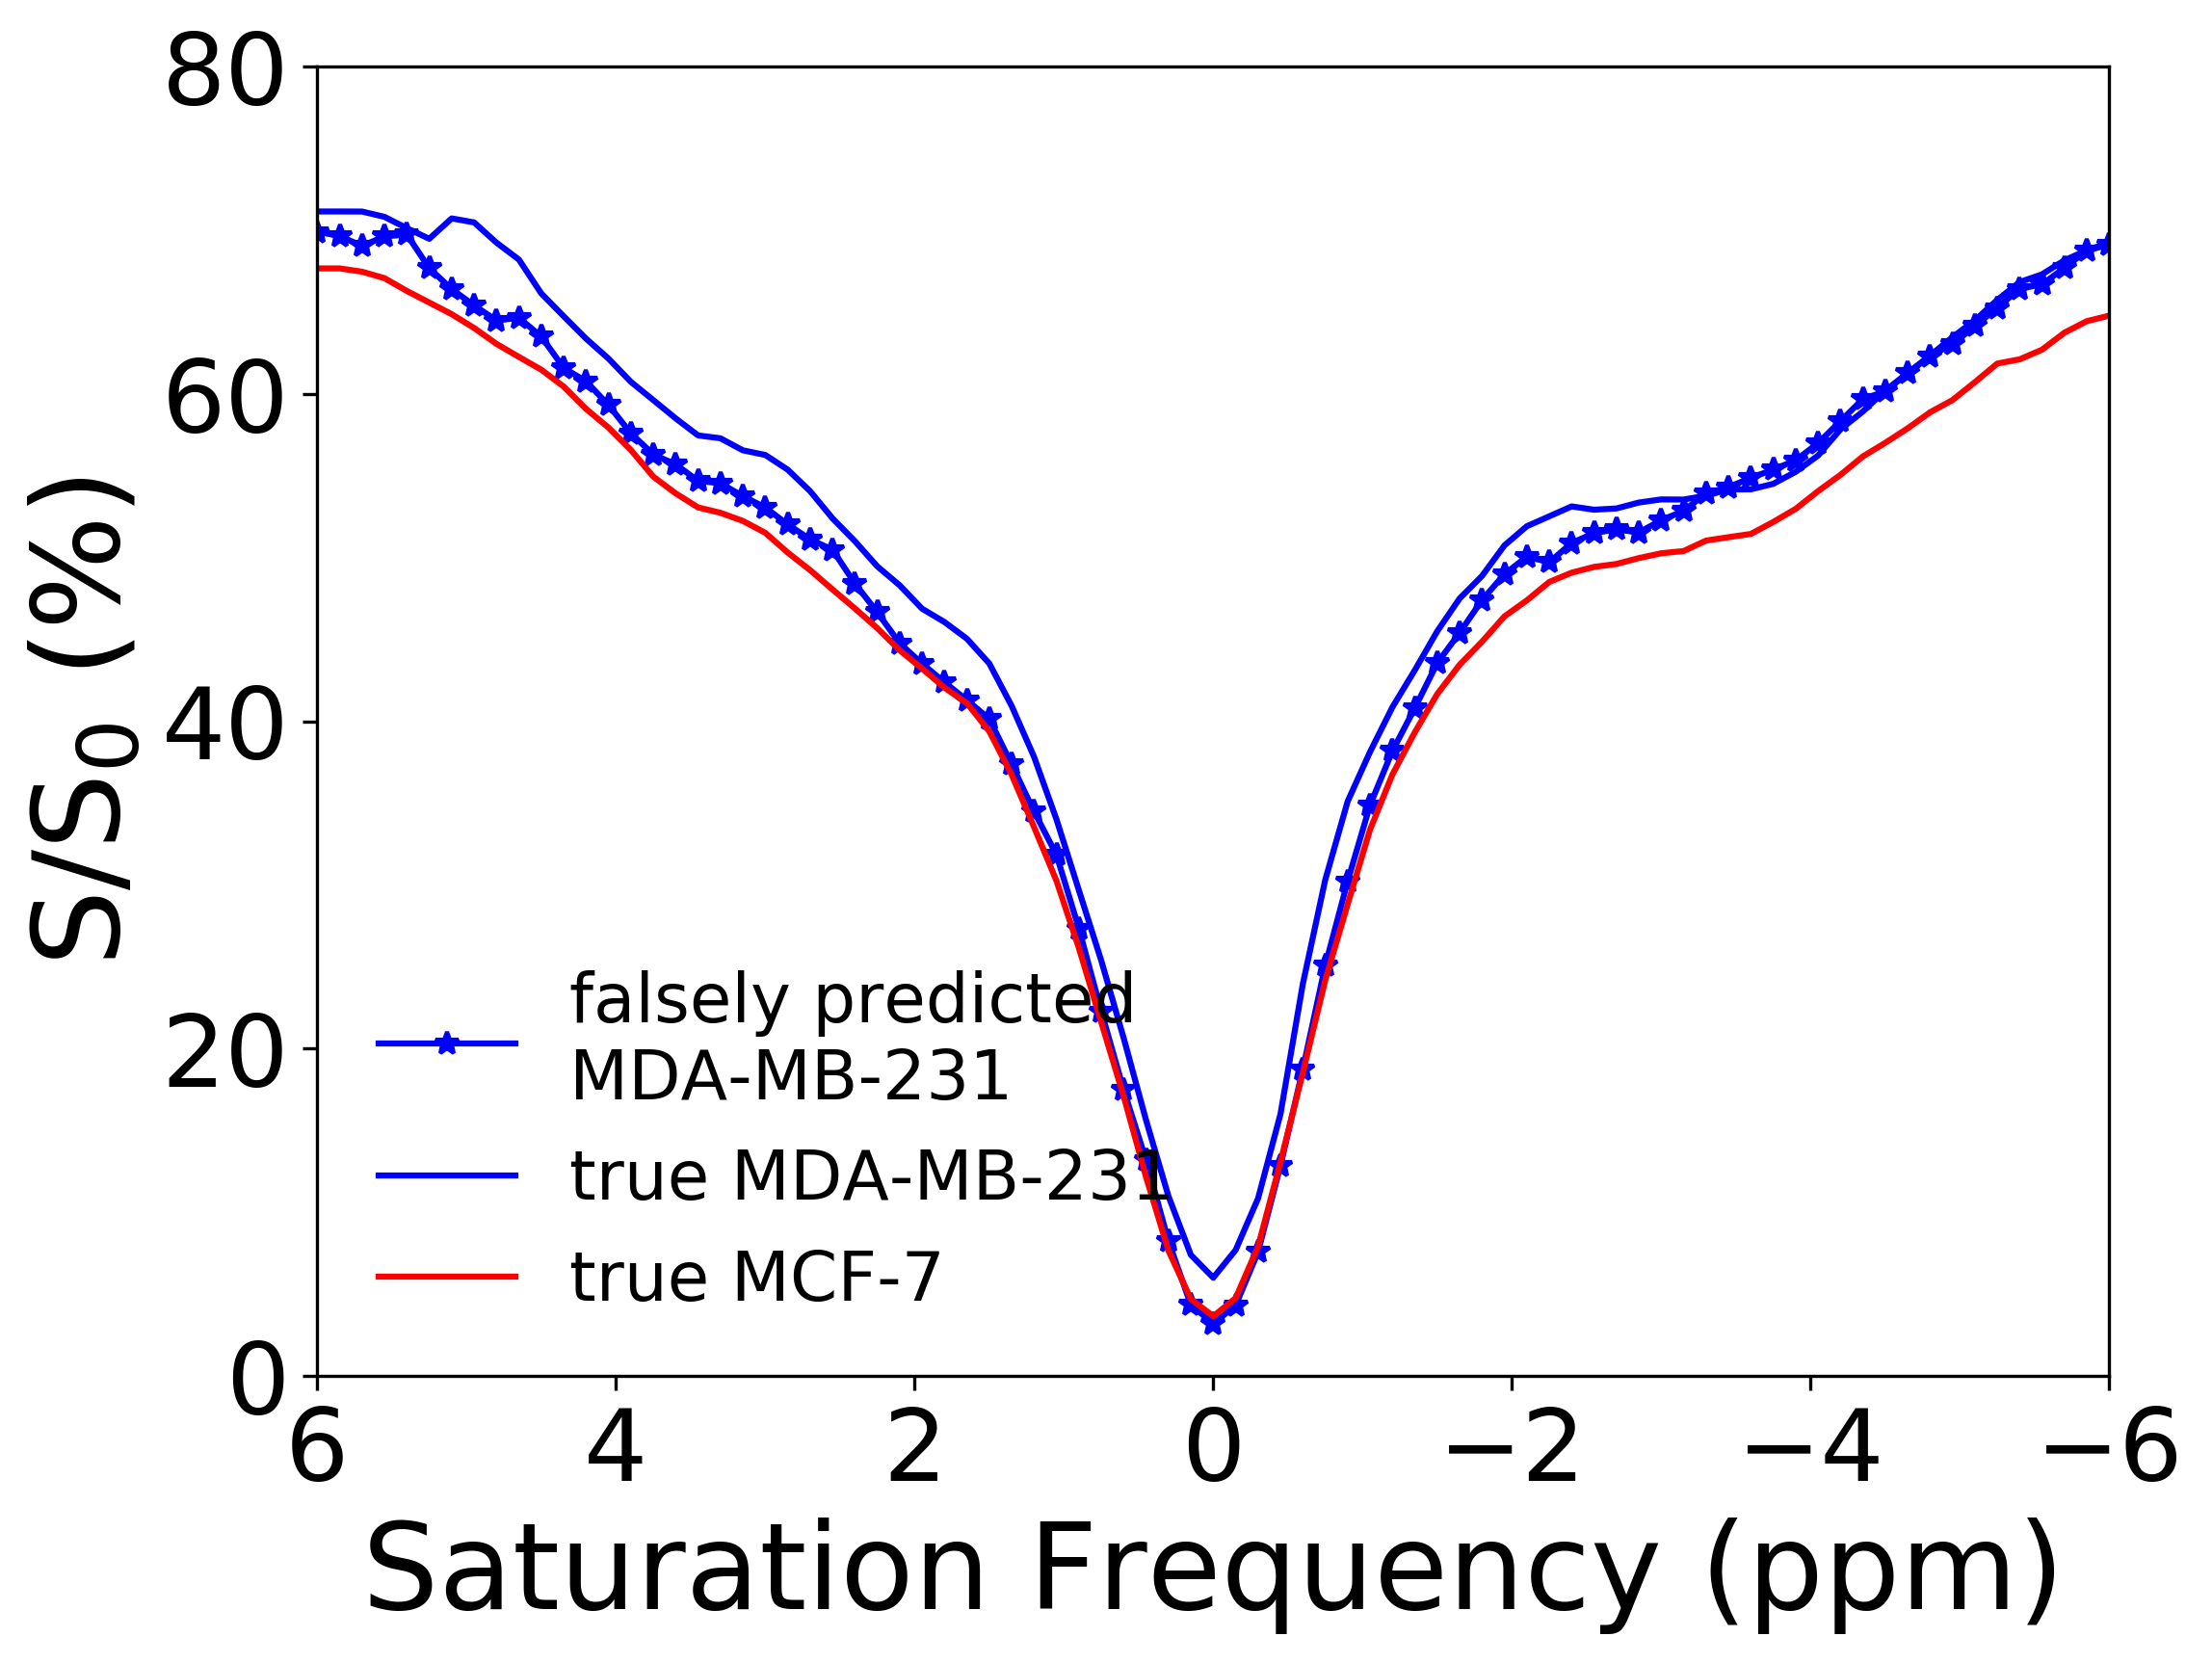

In [293]:
figure(figsize=(8,6), dpi=300)

# plot(cestFreq, data_pulsePowerDependence_masked_test[3,0]*100, 'r*-', label='false predicted\nMDA-MB-231')
plot(cestFreq, data_pulsePowerDependence_masked_test[3,1]*100, 'b*-', label='falsely predicted\nMDA-MB-231')

plot(cestFreq, invivo_MDA231_3_o[2]*100, 'b-', label='true MDA-MB-231')
plot(cestFreq, invivo_MCF7_3_o[2]*100, 'r-', label='true MCF-7')

ylim(0, 80)
xlim(6,-6)
tick_params(labelsize=25)
legend(loc='lower left',frameon=False, fontsize=17)
xlabel('Saturation Frequency (ppm)',fontsize=30)
# xlabel(u'\u0394'+u'\u03C9',fontsize=15)
ylabel('S/S$_0$ (%)',fontsize=30)
xticks([6, 4, 2, 0, -2, -4, -6])